# Ring Attractor Network

Jetzt kommen wir zum zweiten Teil des Seminars, welcher zuerst richtig definiert werden muss.
Nach einiger Recherche bin ich zu dem Schluss gekommen, dass wir nicht nach einem HDC suchen, sondern möchte zunächst ein Ring Attractor Netzwerk aus einem Paper implementieren

## Aufgabe 1:
Implementiere das Netzwerk aus "The geometry of decision-making in individuals and collectives".

## Aufgabe 2:
Nun möchte ich ein ähnliches Experiment wie zuvor ausprobieren. Der Agent soll in einer Umgebung ausgesetzt werden und Futter sammeln. Als Vergleich wäre es natürlich sehr schön ihn in der gleichen Umgebung wie die normalverteilten Random Walker zu testen. 
- Erstelle die gleiche Umgebung wie zuvor
- Da nun die Anzahl der Ziele variiert, muss der Walker die Möglichkeit haben unterschiedlich viele Ziele zu betrachten. Dies wird auf zwei Weisen ausprobiert:
    1. Die Anzahl der Ziele bleibt konstant bei $n_t=10$. Der Agent sieht immer die $n_t$ nächsten Ziele. Wenn ein Ziel aus den nächsten Zielen verschwindet, werden den entsprechenden Spins ein neues Ziel zugeordnet. 
    2. Der Agent sieht alle Ziele in einem Entdeckungsradius. Verschwindet ein Ziel, so werden die zugehörigen spins entfernt, erscheint ein neues Ziel, so werden $n_s = 6$ neue Spins mit dem neuen Ziel und $s=0$ hinzugefügt. Bei $0$ sichtbaren Zielen, soll der Agent zufällige Richtungen wählen. (nicht implementiert)
- Der Agent soll so angepasst werden, dass die Geschwindigkeit konstant bleibt. Dafür wird nur die Richtung beachtet, die der Agent anzeigt.
- Der Agent isst alle Ziele in seinem Essradius und erhöht seinen Score um 1.
- Kann der Algrotihmus angepasst werden, sodass Entfernung einbezogen wird? 
    - overlap Funktion implementieren

## Aufgabe 3
Wir wollen jetzt wirklich eine Ringstruktur erhalten. Dafür definieren wir ein Netzwerk, dass von dem Ansatz vorher inspiriert ist.
Wir platzieren $n=30$ Neuronen, von denen jeder eine Richtung definiert. 

In [1]:
from ring_attractor_search import *

score = 0


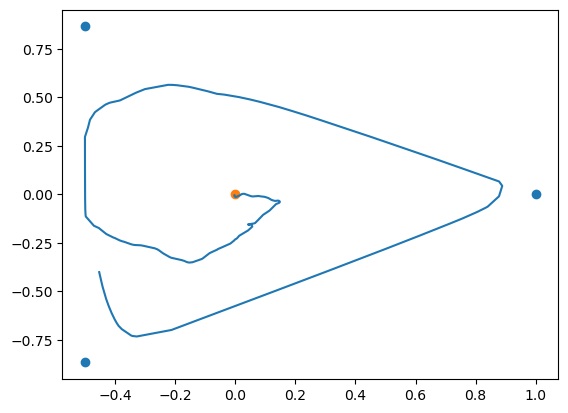

In [8]:
params_main = Parameters(n_steps=1000, v=0.005, n_spins=60, n_targets=3, T=0.2, nu=0.4, r_eat=3,
                     init_target_method="unit_circle", init_target_scale=50, sim_type="", err_dist=0)
inst = Instance(params_main)
inst.update()
inst.draw_trajectory()
print(f"score = {inst.agent.score}")


score = 68


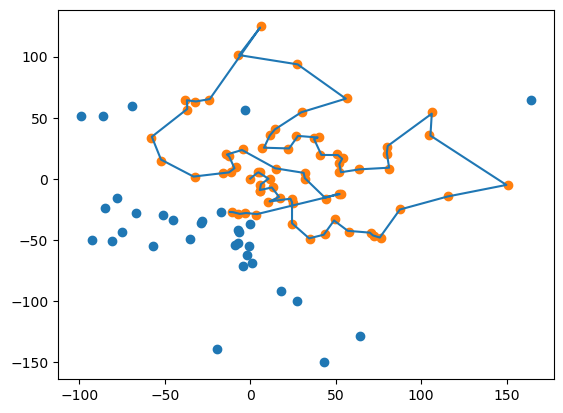

In [6]:
params_main = Parameters(n_steps=10000, v=0.1, n_spins=60, n_targets=100, T=0.15, nu=0.5, r_eat=1, r_detect=10, 
                    max_targets = 1, init_target_method="full_env", init_target_scale=50, sim_type="const_targets")
inst = Instance(params_main)
inst.update()
inst.draw_trajectory()
print(f"score = {inst.agent.score}")


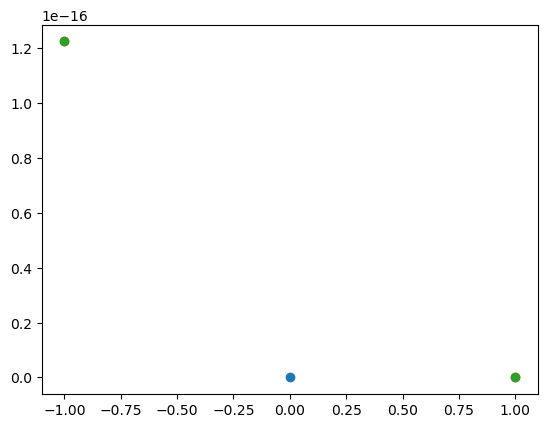

In [73]:
params = Parameters(n_steps=1000, v=0.01, n_spins=60, n_targets=2, T=0.1, nu=0.1, r_eat=3,
                     init_target_method="unit_circle", init_target_scale=50, sim_type="")
inst = Instance(params)
inst.draw_env()
i = 0

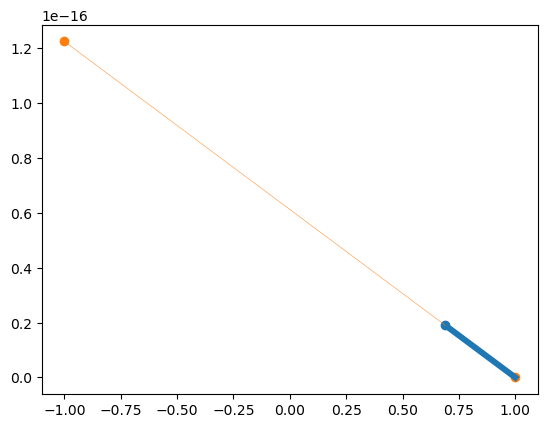

In [98]:
i = inst.some_steps(i,3)

In [45]:
params_main = Parameters(n_steps=10000, v=0.1, n_spins=60, n_targets=100, T=0.15, nu=0.5, r_eat=1, r_detect=10, 
                    max_targets = 1, init_target_method="full_env", init_target_scale=50, sim_type="const_targets")

In [46]:
# find average score over man generations
num_inst = 25
gen = Generation(params_main, num_inst)
gen.sim_gen()
print(np.mean(gen.scores))

72.16


## Working out

### Neural Network

### Ring Attractor


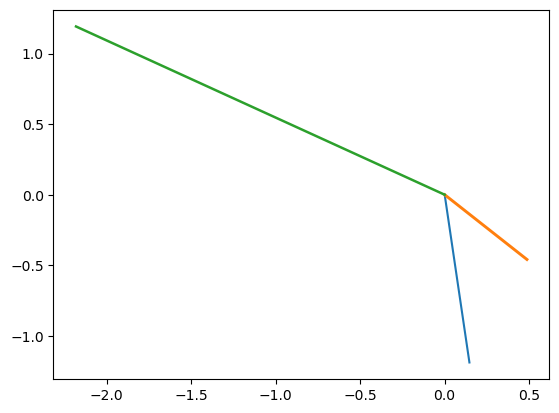

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
init time: 0.15253973007202148, simulation time: 0.26569175720214844


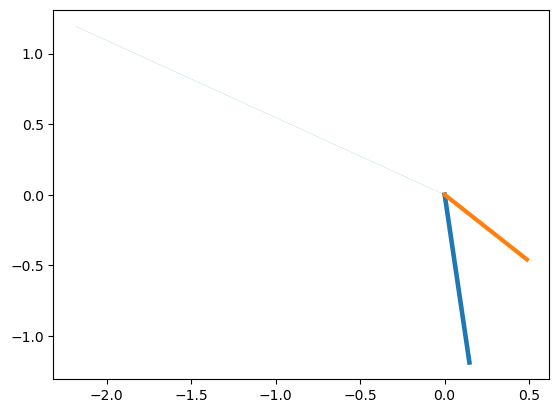

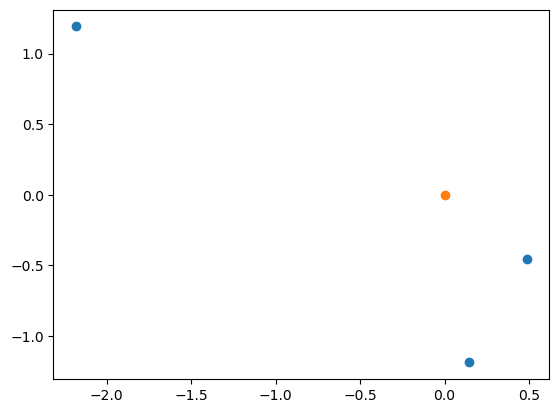

In [153]:


def init(num_s, num_t, nu):
    spin_population = np.random.randint(0, 2, (num_s, 1))

    # target_vectors = np.array([[1+0j], [-1-1j], [1+1j]])
    target_vectors = np.random.randn(num_t,1) + 1.j*np.random.randn(num_t,1)
    spin_targets = np.sort(np.array([np.mod(i, num_t) for i in range(len(spin_population))]))

    J = np.array([[ np.angle(target_vectors[p2].squeeze()) - np.angle(target_vectors[p1].squeeze()) for p2 in spin_targets] for p1 in spin_targets])
    J = np.minimum(np.absolute(J), 2*np.pi - np.absolute(J))
    J = np.cos(np.pi*(J/np.pi)**nu)
    return spin_population, target_vectors, spin_targets, J

# Each spin is given a target an can be turned on or off
def print_step(curr_spins, J, T):
    # minimize energy of the hamiltonian
    delta_spin = np.matmul(curr_spins,curr_spins.T)
    H = -num_targets/N *np.sum(J[delta_spin != 0])
    print(f"H={H}")

    # 1. pick a random spin and flip it
    print(curr_spins.squeeze())
    flip_idx = np.random.randint(0, len(curr_spins))
    curr_spins[flip_idx] = not curr_spins[flip_idx]
    print(curr_spins.squeeze())

    # 2. calculate the energy difference
    delta_spins = np.matmul(curr_spins,curr_spins.T)
    H_flipped = -num_targets/N *np.sum(J[delta_spins != 0])
    print(f"H_flipped={H_flipped}")
    delta_H = H_flipped - H
    print(f"delta_H:{delta_H}")
 
    # 3. if energy is lower than before, keep the flip, else keep it with probability exp(-DH/T)
    if delta_H >= 0:
        if np.random.rand() >= np.exp(-delta_H/T):
            # flip back
            print("flip back")
            curr_spins[flip_idx] = not curr_spins[flip_idx]
    print(curr_spins.squeeze())
    return curr_spins

def flip(curr_spins, J, T, n_targets):
    # minimize energy of the hamiltonian
    delta_spin = np.matmul(curr_spins,curr_spins.T)
    H = -n_targets/N *np.sum(J[delta_spin != 0])

    # 1. pick a random spin and flip it
    flip_idx = np.random.randint(0, len(curr_spins))
    curr_spins[flip_idx] = not curr_spins[flip_idx]

    # 2. calculate the energy difference
    delta_spins = np.matmul(curr_spins,curr_spins.T)
    H_flipped = -n_targets/N *np.sum(J[delta_spins != 0])
    delta_H = H_flipped - H

    # 3. if energy is lower than before, keep the flip, else keep it with probability exp(-DH/T)
    if delta_H >= 0:
        if np.random.rand() >= np.exp(-delta_H/T):
            # flip back
            curr_spins[flip_idx] = not curr_spins[flip_idx]
    return curr_spins


def run_sim(n_spins, n_targets, n_steps, T, nu, start_pos, v0):
    start_time = time.time()
    #init 
    spins, target_vectors, spin_targets, J = init(n_spins, n_targets, nu)
    draw_target(spins, spin_targets, target_vectors)
    init_time = time.time() - start_time
    for i in range(n_steps):
        # update spins
        spins = flip(spins, J, T, n_targets)

        # update position
            # move in direction of spins

            # update target vectors and J
    sim_time = time.time() - start_time
    print(spins.squeeze())

    print(f"init time: {init_time}, simulation time: {sim_time}")
    draw_target(spins, spin_targets, target_vectors)
    

    return target_vectors, spins


start_pos = np.array([0,0])
N = 100
T = 1 # neural noise
nu = 1
n_targets = 3
n_steps = 1000

target_vectors, spins = run_sim(N, n_targets, n_steps, T, nu )

plt.scatter(target_vectors.real, target_vectors.imag)
plt.scatter([0], [0])